In [1]:
import pandas as pd

# Load the data 
bus_stops_file = 'transit-gtfs-stops.csv'
cycling_facilities_file = 'cycling-facilities.csv'

# Reading the data into dataframes
bus_stops_df = pd.read_csv(bus_stops_file)
cycling_facilities_df = pd.read_csv(cycling_facilities_file)


In [2]:
bus_stops_df.describe()

,Code,Description,Zone ID,URL,Location Type,Parent Station ID,Timezone,Wheelchair Boarding
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,830.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
bus_stops_df.isna().sum()

ID                       0
Code                   830
Name                     0
Coordinates              0
Description            830
Zone ID                830
URL                    830
Location Type          830
Parent Station ID      830
Timezone               830
Wheelchair Boarding      0
dtype: int64

To assess the accessibility of bus services in relation to the cycling network, we can perform a spatial analysis. We'll calculate the distance between each bus stop and the nearest cycling facility. This will help us understand how integrated the cycling and bus networks are, which is a key factor in determining accessibility for those who bike to bus stops.

The analysis has calculated the distance from each bus stop to the nearest cycling facility in Kingston. However, there's a crucial note to consider: the distances are currently in degrees because the geographic coordinate system (latitude and longitude) was used. This isn't a useful measure for practical distances.

To make these distances meaningful, we need to convert them into a unit like meters or kilometers. This requires transforming the coordinates from a geographic coordinate system (like WGS84) to a projected coordinate system that allows for distance calculation in linear units.




In [4]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import json

# Function to parse coordinates string into Point geometry
def parse_coordinates(coord_str):
    if isinstance(coord_str, str):
        lat, lon = map(float, coord_str.split(', '))
        return Point(lon, lat)
    return None

# Function to parse GeoJSON string into LineString geometry
def parse_geojson(geojson_str):
    if isinstance(geojson_str, str):
        geojson = json.loads(geojson_str)
        if 'coordinates' in geojson:
            return LineString(geojson['coordinates'])
    return None

# Convert bus stops DataFrame to GeoDataFrame
bus_stops_df['geometry'] = bus_stops_df['Coordinates'].apply(parse_coordinates)
bus_stops_gdf = gpd.GeoDataFrame(bus_stops_df, geometry='geometry')

# Convert cycling facilities DataFrame to GeoDataFrame
cycling_facilities_df['geometry'] = cycling_facilities_df['GeoJSON'].apply(parse_geojson)
cycling_facilities_gdf = gpd.GeoDataFrame(cycling_facilities_df, geometry='geometry')

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
bus_stops_gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is the standard WGS84 latitude and longitude
cycling_facilities_gdf.set_crs(epsg=4326, inplace=True)

# Calculate nearest cycling facility for each bus stop
nearest_facility_distance = bus_stops_gdf.geometry.apply(
    lambda stop: cycling_facilities_gdf.distance(stop).min()
)

# Add the calculated distances to the bus stops dataframe
bus_stops_df['Nearest_Cycling_Facility_Distance'] = nearest_facility_distance

# Displaying the first few rows of the updated bus stops dataframe
bus_stops_df.head()


/var/folders/49/199vrwcn1zqb7rx4rgy0xhbr0000gn/T/ipykernel_3885/733722034.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambda stop: cycling_facilities_gdf.distance(stop).min()


,ID,Code,Name,Coordinates,Description,Zone ID,URL,Location Type,Parent Station ID,Timezone,Wheelchair Boarding,geometry,Nearest_Cycling_Facility_Distance
0,00849,NaN,Clyde Court (south side of Cataraqui Woods),"44.26816, -76.56337",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.56337 44.26816),0.000028
1,00852,NaN,Emerald Street (south side of Crossfield),"44.2643, -76.55754",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55754 44.2643),0.003073
2,09074,NaN,Augusta Drive (south side of Crossfield),"44.26435, -76.55164",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55164 44.26435),0.005604
3,S00399,NaN,Kingston Gospel Temple (south side of Princess),"44.25801, -76.54824",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.54824 44.25801),0.005579
4,00406,NaN,Friarhill Crescent (north side of Waterloo),"44.25398, -76.55169",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55169 44.25398),0.003920


need to  convert these distances into meters for a more comprehensible analysis. 

In [5]:
import pyproj
from shapely.ops import transform
from functools import partial

# Function to convert lat/lon to meters using a projected coordinate system
def convert_to_meters(geometry, target_crs='EPSG:32618'):
    # EPSG:32618 is a UTM zone that should work well for Kingston's latitude and longitude
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),  # source coordinate system (WGS84)
        pyproj.Proj(init=target_crs)    # target coordinate system
    )
    return transform(project, geometry)

# Applying the conversion to both bus stops and cycling facilities
bus_stops_gdf['geometry_meters'] = bus_stops_gdf['geometry'].apply(convert_to_meters)
cycling_facilities_gdf['geometry_meters'] = cycling_facilities_gdf['geometry'].apply(convert_to_meters)

# Recalculating nearest cycling facility distance in meters
nearest_facility_distance_meters = bus_stops_gdf.geometry_meters.apply(
    lambda stop: cycling_facilities_gdf.geometry_meters.distance(stop).min()
)

# Update the dataframe with the new distances in meters
bus_stops_df['Nearest_Cycling_Facility_Distance_Meters'] = nearest_facility_distance_meters

# Displaying the first few rows of the updated dataframe
bus_stops_df.head()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. Se

,ID,Code,Name,Coordinates,Description,Zone ID,URL,Location Type,Parent Station ID,Timezone,Wheelchair Boarding,geometry,Nearest_Cycling_Facility_Distance,Nearest_Cycling_Facility_Distance_Meters
0,00849,NaN,Clyde Court (south side of Cataraqui Woods),"44.26816, -76.56337",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.56337 44.26816),0.000028,2.825492
1,00852,NaN,Emerald Street (south side of Crossfield),"44.2643, -76.55754",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55754 44.2643),0.003073,265.521427
2,09074,NaN,Augusta Drive (south side of Crossfield),"44.26435, -76.55164",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55164 44.26435),0.005604,622.595332
3,S00399,NaN,Kingston Gospel Temple (south side of Princess),"44.25801, -76.54824",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.54824 44.25801),0.005579,460.355615
4,00406,NaN,Friarhill Crescent (north side of Waterloo),"44.25398, -76.55169",NaN,NaN,NaN,NaN,NaN,NaN,0,POINT (-76.55169 44.25398),0.003920,354.346988


We can consider a bus stop to be easily accessible by bike if the nearest cycling facility is within a certain distance, say 500 meters. This distance can be considered a reasonable biking distance for most people. Let's calculate the percentage of bus stops that fall within this accessible range.

In [6]:
# Define a reasonable biking distance (in meters)
accessible_distance = 500  # 500 meters

# Calculate the percentage of bus stops within the accessible distance
accessible_bus_stops = bus_stops_df[bus_stops_df['Nearest_Cycling_Facility_Distance_Meters'] <= accessible_distance]
percentage_accessible = (len(accessible_bus_stops) / len(bus_stops_df)) * 100

percentage_accessible


76.86746987951807

Approximately 76.9% of the bus stops in Kingston are within 500 meters of a cycling facility. This suggests that a significant portion of the bus service in Kingston is accessible for those who might bike to a bus stop.



In [7]:
# Define a reasonable biking distance (in meters)
accessible_distance = 150  # 500 meters

# Calculate the percentage of bus stops within the accessible distance
accessible_bus_stops = bus_stops_df[bus_stops_df['Nearest_Cycling_Facility_Distance_Meters'] <= accessible_distance]
percentage_accessible = (len(accessible_bus_stops) / len(bus_stops_df)) * 100

percentage_accessible


41.9277108433735

Identify and list the names of bus stops that are not within the accessible range (more than 500 meters from a cycling facility).


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of bus stops that are not within the accessible range
non_accessible_bus_stops = bus_stops_df[bus_stops_df['Nearest_Cycling_Facility_Distance_Meters'] > accessible_distance]
non_accessible_names = non_accessible_bus_stops['Name'].tolist()

# Displaying the names of non-accessible bus stops
non_accessible_names



['Emerald Street (south side of Crossfield)',
 'Augusta Drive (south side of Crossfield)',
 'Kingston Gospel Temple (south side of Princess)',
 'Friarhill Crescent (north side of Waterloo)',
 '745 Davis Drive (north side)',
 'Midland Avenue (south side of Norwest)',
 'Lower University Avenue (south side of King)',
 'Maitland Street (south side of King)',
 'Ontario Street (west side of West)',
 'Lower Union Street (east side of Ontario)',
 'William Street (west side of Ontario)',
 'Lower Union Street (west side of Ontario)',
 'King Street (east side of West)',
 'Maitland Street (north side of King)',
 'Lower University Avenue (north side of King)',
 'Henderson Boulevard (east side of Lakeview)',
 'Henderson Boulevard (east side of McEwen)',
 '740 Progress Avenue (north side)',
 'Pembridge Crescent (north side of Taylor-Kidd)',
 '745 Progress Avenue (south side)',
 'Acron Street (west side of McEwen)',
 '279 Lakeview Avenue (west side)',
 'Mona Drive (north side of Taylor-Kidd)',
 'Addin

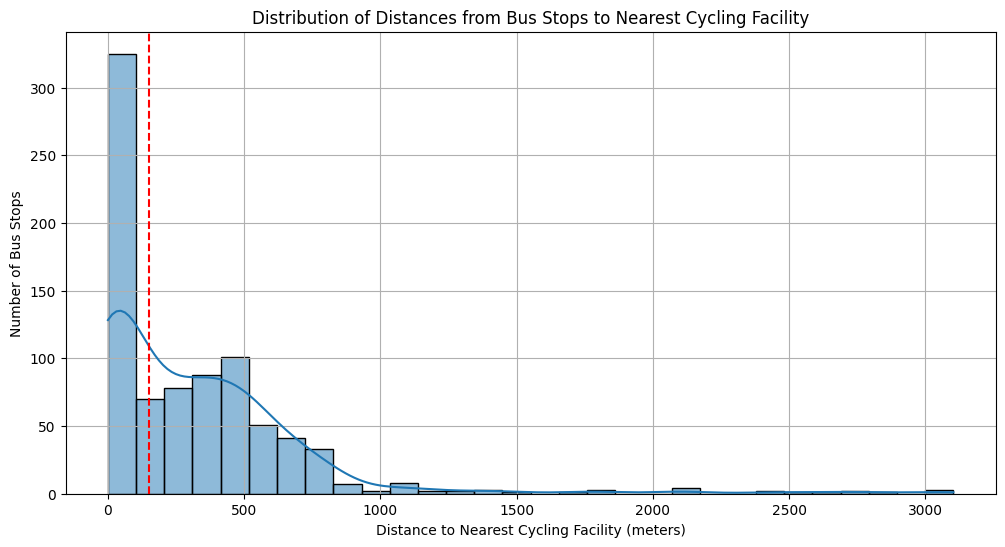

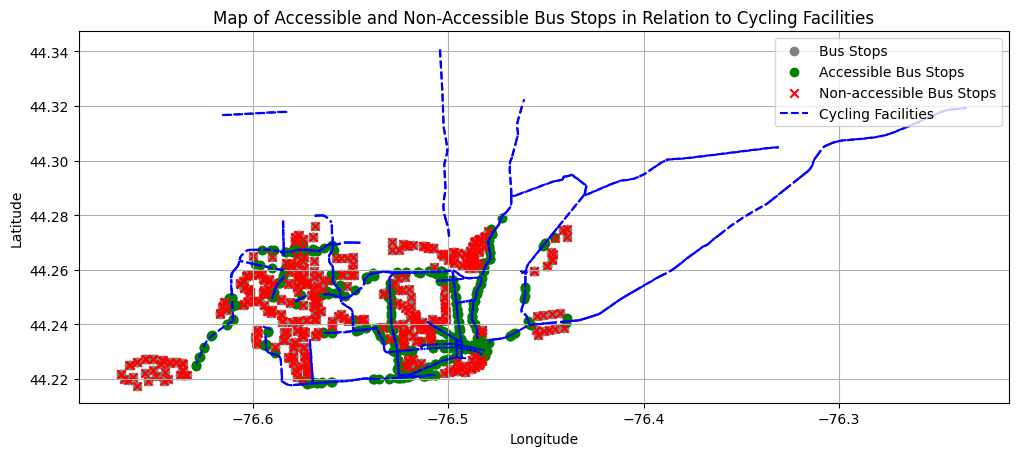

In [9]:
# Plotting the histogram of distances to the nearest cycling facility
plt.figure(figsize=(12, 6))
sns.histplot(bus_stops_df['Nearest_Cycling_Facility_Distance_Meters'], bins=30, kde=True)
plt.axvline(accessible_distance, color='r', linestyle='--')
plt.title('Distribution of Distances from Bus Stops to Nearest Cycling Facility')
plt.xlabel('Distance to Nearest Cycling Facility (meters)')
plt.ylabel('Number of Bus Stops')
plt.grid(True)
plt.show()

# Plotting the map of accessible and non-accessible bus stops
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
bus_stops_gdf.plot(ax=ax, color='grey', label='Bus Stops')
accessible_bus_stops_gdf = bus_stops_gdf[bus_stops_gdf['ID'].isin(accessible_bus_stops['ID'])]
non_accessible_bus_stops_gdf = bus_stops_gdf[bus_stops_gdf['ID'].isin(non_accessible_bus_stops['ID'])]
accessible_bus_stops_gdf.plot(ax=ax, color='green', marker='o', label='Accessible Bus Stops')
non_accessible_bus_stops_gdf.plot(ax=ax, color='red', marker='x', label='Non-accessible Bus Stops')
cycling_facilities_gdf.plot(ax=ax, color='blue', linestyle='--', label='Cycling Facilities')
plt.title('Map of Accessible and Non-Accessible Bus Stops in Relation to Cycling Facilities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


Histogram shows the distribution of distances from bus stops to the nearest cycling facility.
The red dashed line represents the threshold for what we've defined as accessible (500 meters).
Most bus stops are within this accessible range, as indicated by the concentration of data to the left of the red line. 

map Displays the geographic locations of bus stops and cycling facilities.
Accessible bus stops are marked in green, while non-accessible ones are marked in red. Cycling facilities are represented with blue dashed lines.
This plot visually demonstrates the spatial distribution of accessible and non-accessible bus stops relative to cycling infrastructure.


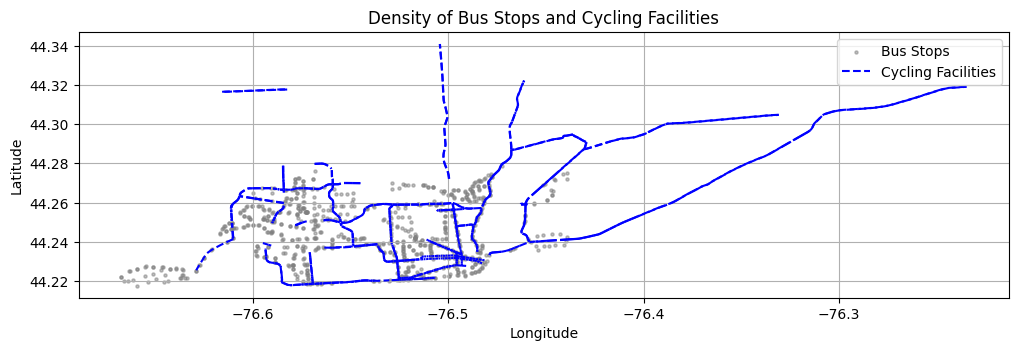

(0.0, 0, 830)

In [13]:
from shapely.geometry import MultiLineString

# Combining all cycling facilities into a single MultiLineString for easier plotting
all_cycling_facilities = MultiLineString([facility for facility in cycling_facilities_gdf.geometry if isinstance(facility, LineString)])

# Create a density plot for bus stops
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
bus_stops_gdf.plot(ax=ax, color='grey', marker='o', label='Bus Stops', markersize=5, alpha=0.5)
gpd.GeoSeries(all_cycling_facilities).plot(ax=ax, color='blue', linestyle='--', label='Cycling Facilities')
plt.title('Density of Bus Stops and Cycling Facilities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# Analyzing wheelchair accessibility
wheelchair_accessible_stops = bus_stops_df[bus_stops_df['Wheelchair Boarding'] == 1]
non_wheelchair_accessible_stops = bus_stops_df[bus_stops_df['Wheelchair Boarding'] == 0]

# Percentage of wheelchair accessible stops
percentage_wheelchair_accessible = (len(wheelchair_accessible_stops) / len(bus_stops_df)) * 100

percentage_wheelchair_accessible, len(wheelchair_accessible_stops), len(non_wheelchair_accessible_stops)


Density Analysis: Determine areas with high densities of bus stops and compare them with the cycling network's coverage

The density plot visualizes the distribution of bus stops (in grey) in relation to the cycling facilities (blue dashed lines).
This visualization can help identify areas with high concentrations of bus stops and their proximity to cycling facilities. Such areas might indicate high public transport usage or urban centers.